In [3]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats

# Problem 1

In [4]:
# Generating a Poisson background with mean of 100.
background = stats.poisson.rvs(100,size=1000000)

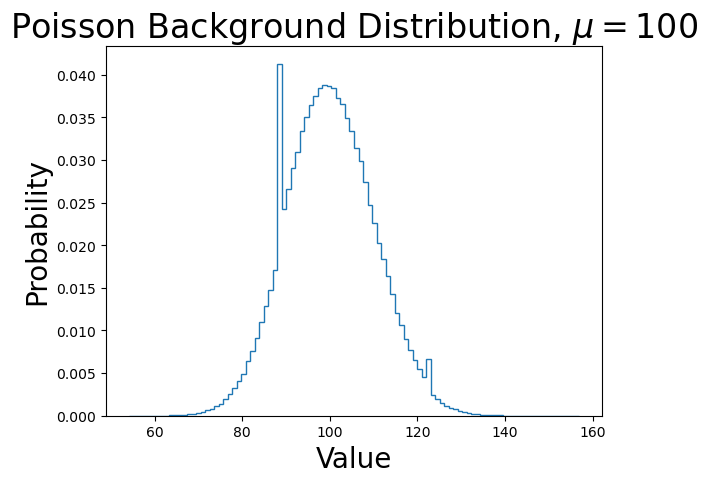

In [5]:
# plotting the background
plt.title("Poisson Background Distribution, $\mu=100$",fontsize=24)
plt.xlabel('Value',fontsize=20)
plt.ylabel('Probability',fontsize=20)

plt.hist(background, histtype='step',density=True,bins=100)

plt.show()

In the above graph, we see the generated background distribution of a Poisson with a mean of 100. This graph looks remarkably like a normal distribution, and this is due to the fact that a Poisson with a high mean begins to approximate a Gaussian.

In [6]:
# Finds probability of 5 sigma event
prob = stats.norm.cdf(5)

# Finds the inverse of the probility, i.e. the number of events needed for a 5 sigma reading
events = stats.poisson.ppf(prob, mu=100)
print("The 5 sigma threshold for a Poisson Distribution (mu = 100) is {} events.".format(events))

The 5 sigma threshold for a Poisson Distribution (mu = 100) is 154.0 events.


The above code first looks at a 0 centered Gaussian with a standard deviation of 1. It finds the area under the curve between 5 and infinity, or in other words the odds that a measurement would be 5 or higher. This probability is then passed into the percent point function of a Poisson with a mean of 100. The percent point function finds the point along the distribution with the given mean where the integral from that point to infinity is equal to the number passed in. So ```events = stats.poisson.ppf(prob, mu=100)``` is solving for $a$ in the equation $\int_{events}^{a} \frac{100^x}{x!}e^{-100}dx = \int_{5}^{\infty}\frac{1}{2\pi}e^{-\frac{1}{2}x^2}dx$. In this equation, a is 154.

# Problem 2

In [26]:
# Generating a signal
min_signal = stats.poisson.ppf(stats.norm.cdf(8), 100)
max_signal = stats.poisson.ppf(stats.norm.cdf(30), 100)
print("Minimum Signal:\t{}\nMaximum Signal:\t{}".format(min_signal, max_signal))

Minimum Signal:	190.0
Maximum Signal:	inf


We can see from the above that the minimum signal strength for the problem (8 $\sigma$) would be a measurement of 190 events or higher. However, when we look for a maximum value, we see that this is infinity, which is not the case at all. This is due to the limitations of the computer with respect to bit precision. There are not enough bits for the computer to be able to calculate ```stats.norm.cdf(9)``` to the level of precision needed, let alone ```stats.norm.cdf(9)```. However, treating the distribution as a Gaussian, which was discussed above for reference, we can create a rough maximum for a 30 $\sigma$ signal. We know 8 $\sigma$ is at 190 events, while 5 $\sigma$ is at 154 events. Thus, each $\sigma$ equates to roughly 12 events ($\frac{190-154}{8-5} = 12$). So we can expect 30 $\sigma$ to be equal to 360 events. Using the bounds of 190 to 360, I chose to use 192 as my signal strength ($\sigma = 8.2$), as I am anticipating more errors as a result of harware limitations.

## A)

In [77]:
signal_mean = 192
signal = stats.poisson.rvs(192,size=200000)

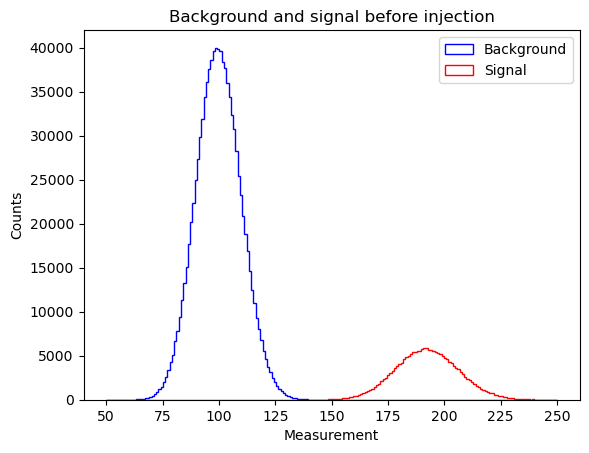

In [99]:
plt.cla()
plt.hist([signal, background], bins = np.linspace(50,250,200), histtype = 'step', color=['r', 'b'], label=['Signal', 'Background'])
plt.title('Background and Signal pre-injection')
plt.xlabel('Measurement')
plt.ylabel('Counts')
plt.legend()
plt.show()

Here we can see the distributions of the two signals. In blue we see the background signal, while in red, we have our generated signal. The generated signal is of the form of a Poisson since this is a problem involving counting particles, which is naturally modeled by a Poisson for lower values. We can see that the signal plotted is as expected, a Poisson with a mean of 192. 

## A)

192.0

0.9999999999999999